#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Aivle/DL/AI_미니프로젝트 1차_실습자료/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩
    - pandas, numpy,matplotlib,seaborn, joblib 을 로딩하고
    필요한 라이브러리를 로딩합니다.
    <br>(분류 모델에서는 이번에 RandomForestClassifier를 씁니다. 더 많은 분류 모델을 써도 됩니다!)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [5]:
# 주어진 데이터 셋을 불러오세요.
train_data = pd.read_csv(path + 'data01_train.csv')
test_data = pd.read_csv(path + 'data01_test.csv')
feature_data = pd.read_csv(path + 'features.csv')

In [6]:
#불필요한 칼럼을 삭제하세요.
train_data.drop(['subject'], axis=1, inplace=True)
test_data.drop(['subject'], axis=1, inplace=True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [7]:
# 전체 데이터의 행, 열 개수를 확인
print(train_data.shape)
print(test_data.shape)

(5881, 562)
(1471, 562)


In [8]:
# 전체 데이터의 상위 5개 행 확인
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [9]:
# 전체 데이터의 상위 5개 행 확인
test_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [10]:
# 전체 데이터의 수치형 변수 분포 확인
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238
...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",5881.0,0.009340,0.608190,-1.000000,-0.481718,0.011448,0.499857,0.998702
"angle(tBodyGyroJerkMean,gravityMean)",5881.0,-0.007099,0.476738,-1.000000,-0.373345,-0.000847,0.356236,0.996078
"angle(X,gravityMean)",5881.0,-0.491501,0.509069,-1.000000,-0.811397,-0.709441,-0.511330,0.977344
"angle(Y,gravityMean)",5881.0,0.059299,0.297340,-1.000000,-0.018203,0.182893,0.248435,0.478157


In [11]:
#전체 데이터의 모든 변수 확인
train_data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.622617,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.196921,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS


In [12]:
#(추가) 다양하게 기본 정보들을 확인하세요!
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [13]:
# Activity 에 대해서 단변량 분석을 시행합니다. (범주별 빈도수, 종류, 비율, 시각화도 해보기!)

In [14]:
print(train_data['Activity'].value_counts())
print('-' * 28)
print(train_data['Activity'].value_counts(normalize=True))

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
----------------------------
Activity
LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: proportion, dtype: float64


<Axes: xlabel='Activity', ylabel='count'>

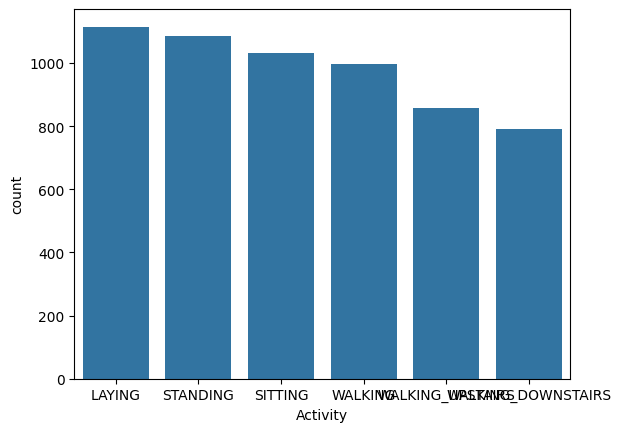

In [15]:
sns.barplot(x=train_data['Activity'].value_counts().index, y=train_data['Activity'].value_counts())

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [16]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
feature_data['sensor'].value_counts()

,count
sensor,
fBodyGyro,79
fBodyAccJerk,79
fBodyAcc,79
tBodyAcc,40
tGravityAcc,40
tBodyAccJerk,40
tBodyGyroJerk,40
tBodyGyro,40
tGravityAccMag,13


In [17]:
#센서 그룹 데이터의 'agg'변수의 값 확인
feature_data['agg'].value_counts()

,count
agg,
bandsEnergy(),126
arCoeff(),60
std(),33
mad(),33
max(),33
energy(),33
min(),33
entropy(),33
iqr(),33


In [18]:
#센서 그룹 데이터의 'axis'변수의 값 확인
feature_data['axis'].value_counts()

,count
axis,
X,76
Y,76
Z,76
gravityMean,6
"X,2",5
...,...
"17,32.2",2
"49,64.2",2
"1,24.2",2


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [19]:
# 데이터 분할을 위한 전처리
x_t, y_t = train_data.drop(['Activity'], axis=1), train_data['Activity']
x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=0.2, random_state=42)

In [20]:
x_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4704 entries, 3116 to 860
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 20.2 MB
<class 'pandas.core.series.Series'>
Index: 4704 entries, 3116 to 860
Series name: Activity
Non-Null Count  Dtype 
--------------  ----- 
4704 non-null   object
dtypes: object(1)
memory usage: 73.5+ KB


#### 2) 모델링

In [21]:
#생성
model = RandomForestClassifier()
#학습
model.fit(x_train, y_train)
#평가
model.score(x_val, y_val)

0.9796091758708582

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(x_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[231   0   0   0   0   0]
 [  0 195   5   0   0   0]
 [  0   7 219   0   0   0]
 [  0   0   0 194   2   2]
 [  0   0   0   4 140   1]
 [  0   0   0   0   3 174]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       231
           SITTING       0.97      0.97      0.97       200
          STANDING       0.98      0.97      0.97       226
           WALKING       0.98      0.98      0.98       198
WALKING_DOWNSTAIRS       0.97      0.97      0.97       145
  WALKING_UPSTAIRS       0.98      0.98      0.98       177

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



#### 3) 변수 중요도 추출

['/content/drive/MyDrive/Aivle/DL/AI_미니프로젝트 1차_실습자료/Activity_importance.pkl']

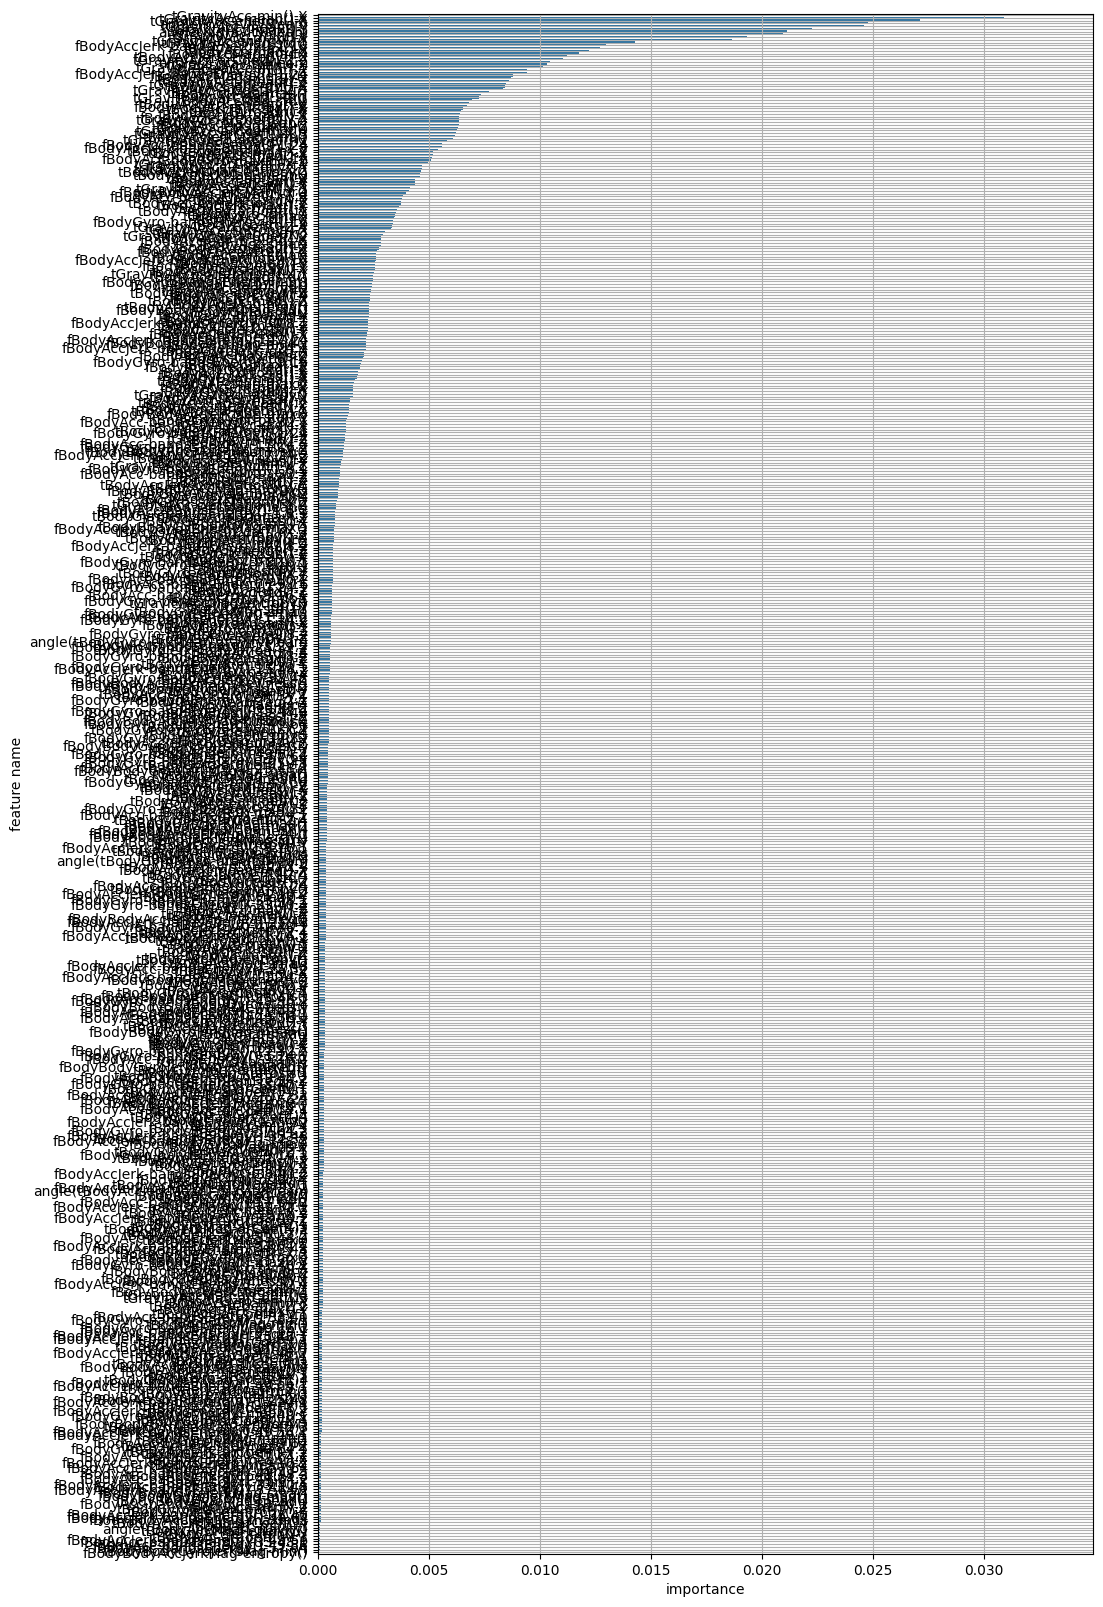

In [24]:
# 변수 중요도 추출(시각화로 나타내기)
joblib.dump(plot_feature_importance(model.feature_importances_, x_train.columns),path + 'Activity_importance.pkl')

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [25]:
# 중요도 상위 top 5
importances = pd.Series(model.feature_importances_, index=x_train.columns)

top_5 = importances.sort_values(ascending=False).head(5)
print("🔝 상위 5개 중요 변수:")
print(top_5)


🔝 상위 5개 중요 변수:
tGravityAcc-min()-X       0.033254
tGravityAcc-mean()-X      0.030896
tGravityAcc-energy()-X    0.027120
angle(Y,gravityMean)      0.024792
tGravityAcc-mean()-Y      0.024591
dtype: float64


In [26]:
# 중요도 하위 top 5

bottom_5 = importances.sort_values().head(5)
print("\n🔻 하위 5개 중요 변수:")
print(bottom_5)


🔻 하위 5개 중요 변수:
fBodyBodyAccJerkMag-entropy()     0.000036
fBodyBodyGyroJerkMag-min()        0.000082
fBodyAcc-bandsEnergy()-57,64      0.000091
fBodyAcc-bandsEnergy()-49,56      0.000093
fBodyAcc-bandsEnergy()-33,48.1    0.000096
dtype: float64


#### 2) 상위 5개 변수에 대한 분석
        - 위에서 나온 상위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

<Axes: xlabel='tGravityAcc-min()-X', ylabel='Density'>

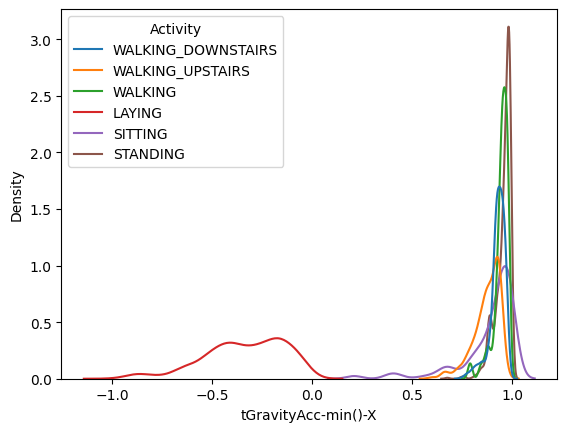

In [27]:
#1위 : oooo
sns.kdeplot(x=x_train[top_5.index[0]], hue=y_train)

<Axes: xlabel='tGravityAcc-mean()-X', ylabel='Density'>

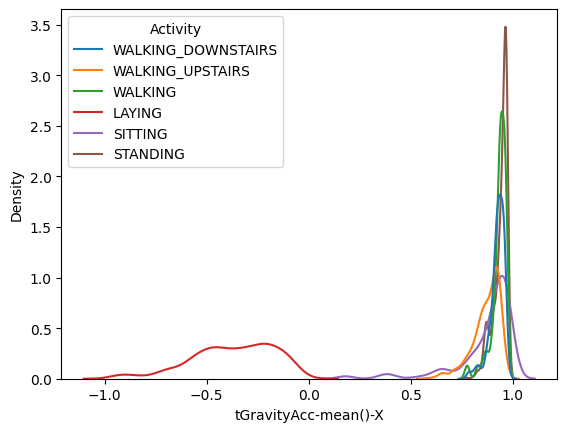

In [28]:
#2위: vvvvv
sns.kdeplot(x=x_train[top_5.index[1]], hue=y_train)

<Axes: xlabel='tGravityAcc-energy()-X', ylabel='Density'>

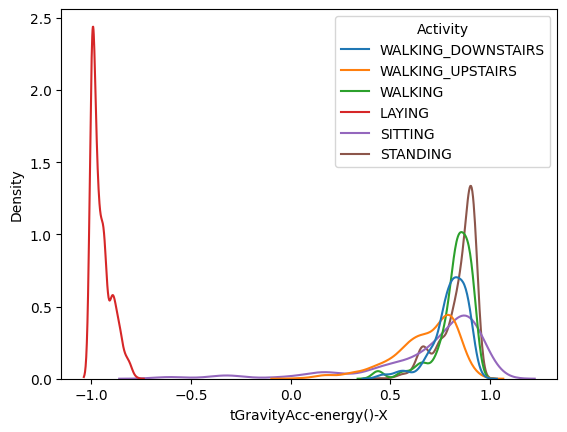

In [29]:
sns.kdeplot(x=x_train[top_5.index[2]], hue=y_train)

<Axes: xlabel='angle(Y,gravityMean)', ylabel='Density'>

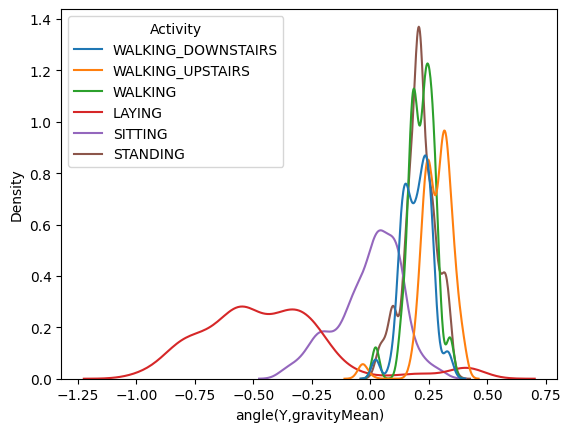

In [30]:
sns.kdeplot(x=x_train[top_5.index[3]], hue=y_train)

<Axes: xlabel='tGravityAcc-mean()-Y', ylabel='Density'>

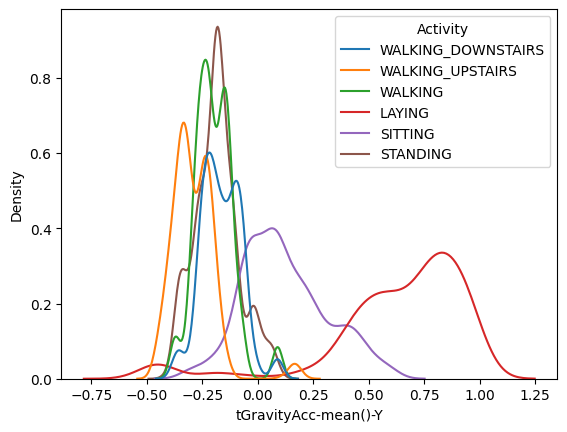

In [31]:
sns.kdeplot(x=x_train[top_5.index[4]], hue=y_train)

#### 3) 하위 5개 변수에 대한 분석
        - 위에서 하위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

<Axes: xlabel='fBodyBodyAccJerkMag-entropy()', ylabel='Density'>

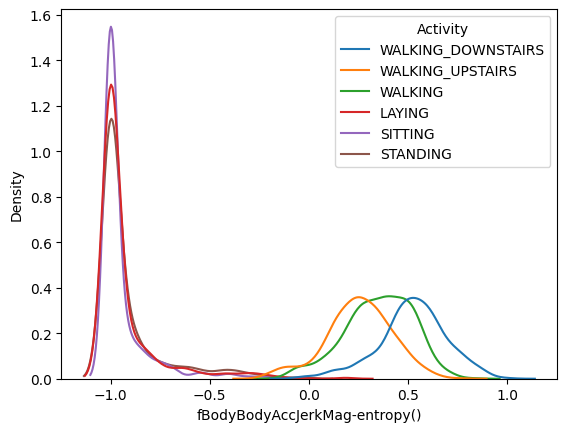

In [32]:
#1위 : oooo
sns.kdeplot(x=x_train[bottom_5.index[0]], hue=y_train)

<Axes: xlabel='fBodyBodyGyroJerkMag-min()', ylabel='Density'>

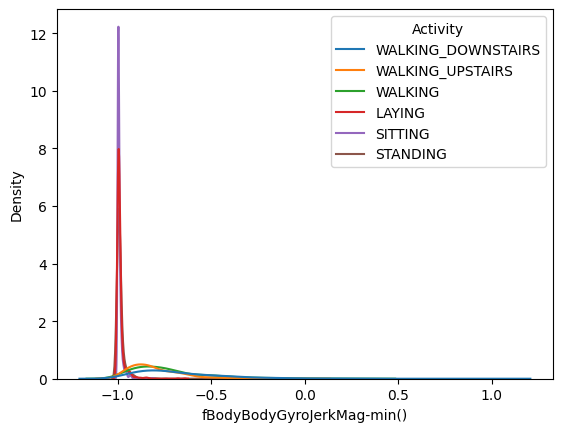

In [33]:
#2위: vvvvv
sns.kdeplot(x=x_train[bottom_5.index[1]], hue=y_train)

<Axes: xlabel='fBodyAcc-bandsEnergy()-57,64', ylabel='Density'>

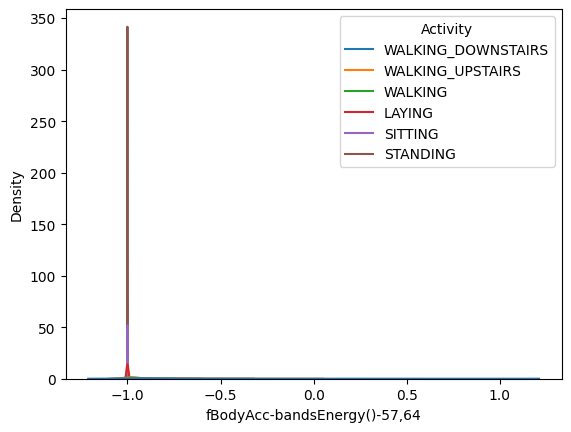

In [34]:
sns.kdeplot(x=x_train[bottom_5.index[2]], hue=y_train)

<Axes: xlabel='fBodyAcc-bandsEnergy()-49,56', ylabel='Density'>

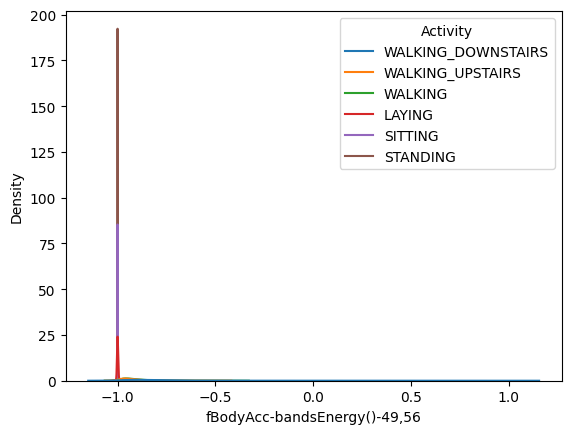

In [35]:
sns.kdeplot(x=x_train[bottom_5.index[3]], hue=y_train)

<Axes: xlabel='fBodyAcc-bandsEnergy()-33,48.1', ylabel='Density'>

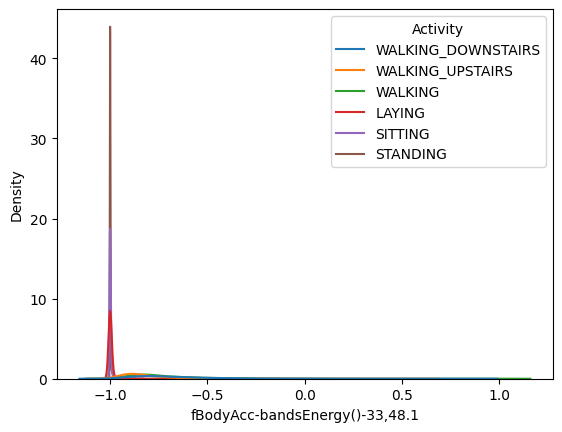

In [36]:
sns.kdeplot(x=x_train[bottom_5.index[4]], hue=y_train)

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.


#### 1) is_dynamic 추가

In [37]:
#is dynamic 변수를 추가하세요(값 0, 값 1 확인해서!)
train_data['is_dynamic'] = train_data['Activity'].apply(lambda x : 0 if x in ['STANDING', 'SITTING', 'LAYING'] else 1)
test_data['is_dynamic'] = test_data['Activity'].apply(lambda x : 0 if x in ['STANDING', 'SITTING', 'LAYING'] else 1)

In [38]:
print(train_data['is_dynamic'].value_counts())
print('-' * 28)
print(test_data['is_dynamic'].value_counts())

is_dynamic
0    3234
1    2647
Name: count, dtype: int64
----------------------------
is_dynamic
0    833
1    638
Name: count, dtype: int64


#### 2) 기본모델 생성

In [39]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, y_train = train_data.drop(['Activity', 'is_dynamic'], axis=1), train_data['is_dynamic']
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [40]:
#RandomForestClassifier로 모델링 진행
model = RandomForestClassifier()
model.fit(x_train, y_train)
model.score(x_val, y_val)

1.0

#### 3) 변수중요도 상위 5개 분석

['/content/drive/MyDrive/Aivle/DL/AI_미니프로젝트 1차_실습자료/is_dynamic.pkl']

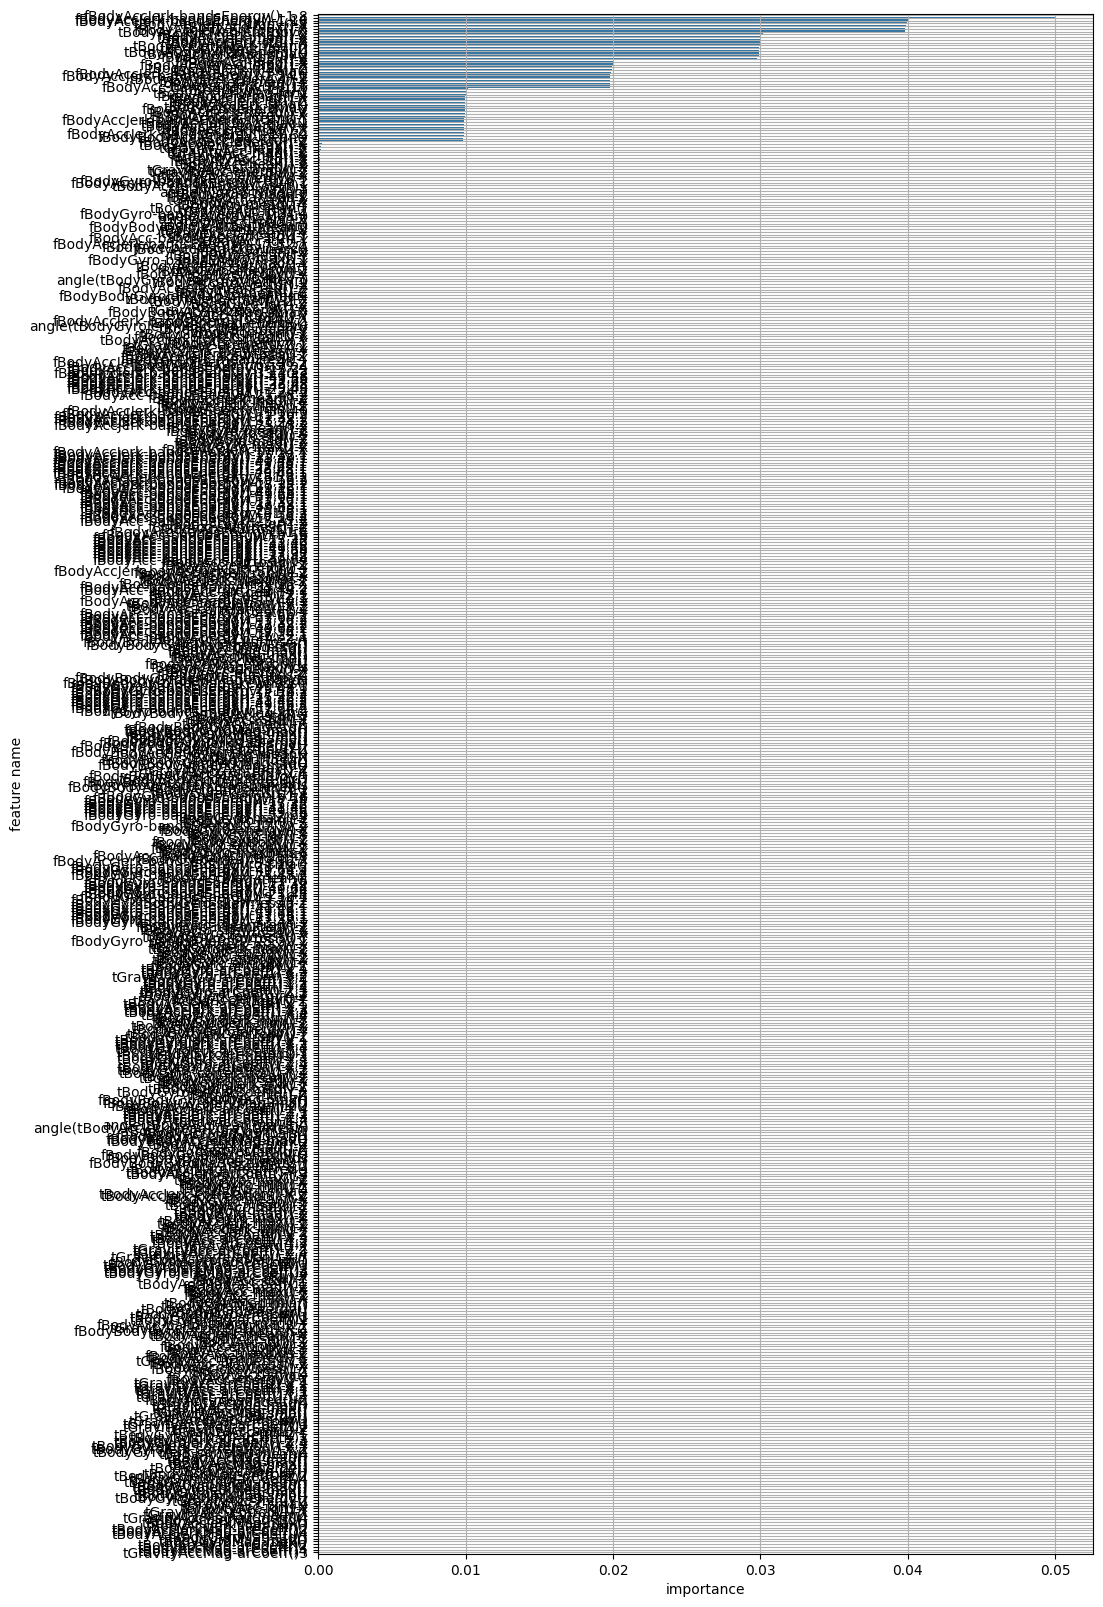

In [41]:
# 변수 중요도 추출(시각화로 나타내기)
joblib.dump(plot_feature_importance(model.feature_importances_, x_train.columns),path + 'is_dynamic.pkl')

In [42]:
# is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석!
importances = pd.Series(model.feature_importances_, index=x_train.columns)

top_5 = importances.sort_values(ascending=False).head(5)
print("🔝 상위 5개 중요 변수:")
print(top_5)

🔝 상위 5개 중요 변수:
fBodyAccJerk-bandsEnergy()-1,8     0.050071
fBodyAccJerk-bandsEnergy()-1,24    0.050042
fBodyAccJerk-bandsEnergy()-1,16    0.040077
tBodyAccJerk-entropy()-X           0.039923
tBodyAcc-max()-X                   0.039906
dtype: float64


* 미션1에서 했던 것 처럼 상위 5개의 변수 데이터를 탐색해보기!

<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,8', ylabel='Density'>

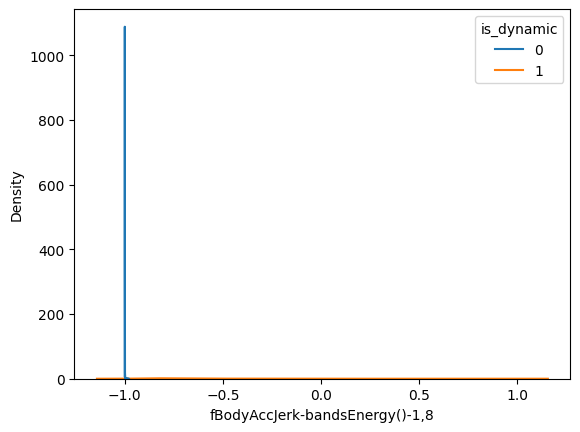

In [43]:
#1위: fBodyAccJerk-bandsEnergy()-1,24
sns.kdeplot(x=x_train[top_5.index[0]], hue=y_train)

<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,24', ylabel='Density'>

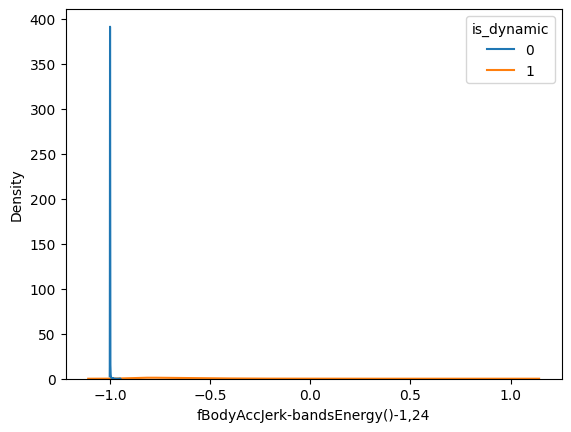

In [44]:
#2위: fBodyAccJerk-bandsEnergy()-1,16
sns.kdeplot(x=x_train[top_5.index[1]], hue=y_train)

<Axes: xlabel='fBodyAccJerk-bandsEnergy()-1,16', ylabel='Density'>

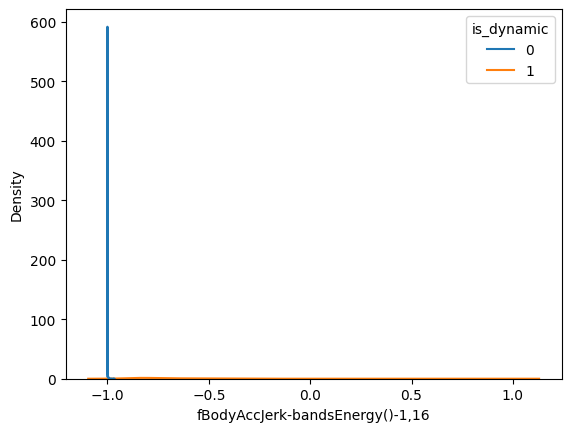

In [45]:
sns.kdeplot(x=x_train[top_5.index[2]], hue=y_train)

<Axes: xlabel='tBodyAccJerk-entropy()-X', ylabel='Density'>

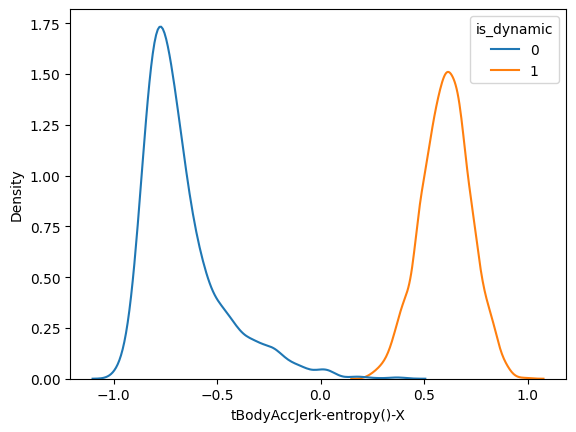

In [46]:
sns.kdeplot(x=x_train[top_5.index[3]], hue=y_train)

<Axes: xlabel='tBodyAcc-max()-X', ylabel='Density'>

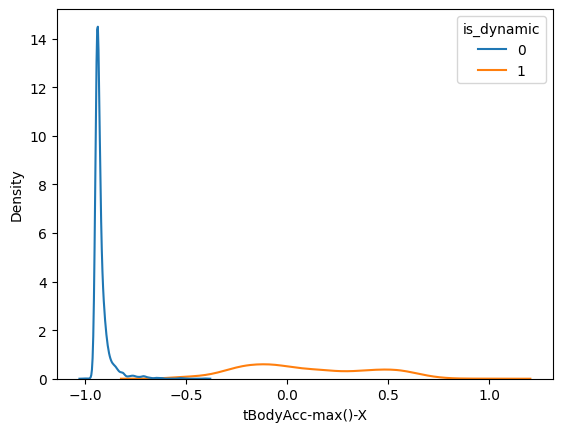

In [47]:
sns.kdeplot(x=x_train[top_5.index[4]], hue=y_train)

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [51]:
# tip : rename을 써서 칼럼 이름 수정을 해야합니다!
act = joblib.load(path + 'Activity_importance.pkl')
act.rename(columns={'feature_importance':'Activity_importance'}, inplace=True)
act

,feature_name,Activity_importance
0,tGravityAcc-min()-X,0.033254
1,tGravityAcc-mean()-X,0.030896
2,tGravityAcc-energy()-X,0.027120
3,"angle(Y,gravityMean)",0.024792
4,tGravityAcc-mean()-Y,0.024591
...,...,...
556,"fBodyAcc-bandsEnergy()-33,48.1",0.000096
557,"fBodyAcc-bandsEnergy()-49,56",0.000093
558,"fBodyAcc-bandsEnergy()-57,64",0.000091
559,fBodyBodyGyroJerkMag-min(),0.000082


In [52]:
is_dynamic = joblib.load(path + 'is_dynamic.pkl')
is_dynamic.rename(columns={'feature_importance':'is_dynamic_importance'}, inplace=True)
is_dynamic

,feature_name,is_dynamic_importance
0,"fBodyAccJerk-bandsEnergy()-1,8",0.050071
1,"fBodyAccJerk-bandsEnergy()-1,24",0.050042
2,"fBodyAccJerk-bandsEnergy()-1,16",0.040077
3,tBodyAccJerk-entropy()-X,0.039923
4,tBodyAcc-max()-X,0.039906
...,...,...
556,tBodyGyroMag-max(),0.000000
557,tBodyAccMag-arCoeff()2,0.000000
558,tBodyAccMag-arCoeff()3,0.000000
559,tBodyAccMag-arCoeff()4,0.000000


#### 2) 합치기

In [60]:
# merge 해서 2개를 합치는 작업하기
merged = pd.merge(act, is_dynamic, on="feature_name", how="outer")
merged

,feature_name,Activity_importance,is_dynamic_importance
0,"angle(X,gravityMean)",0.021113,0.000043
1,"angle(Y,gravityMean)",0.024792,0.000077
2,"angle(Z,gravityMean)",0.010439,0.000034
3,"angle(tBodyAccJerkMean),gravityMean)",0.000235,0.000000
4,"angle(tBodyAccMean,gravity)",0.000103,0.000000
...,...,...,...
556,tGravityAccMag-max(),0.003003,0.000000
557,tGravityAccMag-mean(),0.000183,0.000000
558,tGravityAccMag-min(),0.000281,0.000000
559,tGravityAccMag-sma(),0.000436,0.000000


In [61]:
merged1 = pd.merge(merged, feature_data, on='feature_name', how='outer')
merged1

,feature_name,Activity_importance,is_dynamic_importance,sensor,agg,axis
0,"angle(X,gravityMean)",0.021113,0.000043,angle,X,gravityMean
1,"angle(Y,gravityMean)",0.024792,0.000077,angle,Y,gravityMean
2,"angle(Z,gravityMean)",0.010439,0.000034,angle,Z,gravityMean
3,"angle(tBodyAccJerkMean),gravityMean)",0.000235,0.000000,angle,tBodyAccJerkMean,gravityMean
4,"angle(tBodyAccMean,gravity)",0.000103,0.000000,angle,tBodyAccMean,gravity
...,...,...,...,...,...,...
556,tGravityAccMag-max(),0.003003,0.000000,tGravityAccMag,max(),NaN
557,tGravityAccMag-mean(),0.000183,0.000000,tGravityAccMag,mean(),NaN
558,tGravityAccMag-min(),0.000281,0.000000,tGravityAccMag,min(),NaN
559,tGravityAccMag-sma(),0.000436,0.000000,tGravityAccMag,sma(),NaN


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [62]:
# joblib.dump 이용해서 colab에 .pkl 파일에 저장하기(tip: path + '파일 이름.pkl')
joblib.dump(merged1, path + 'feature_importance.pkl')

['/content/drive/MyDrive/Aivle/DL/AI_미니프로젝트 1차_실습자료/feature_importance.pkl']

In [63]:
importances_pkl = joblib.load(path + 'feature_importance.pkl')
importances_pkl

,feature_name,Activity_importance,is_dynamic_importance,sensor,agg,axis
0,"angle(X,gravityMean)",0.021113,0.000043,angle,X,gravityMean
1,"angle(Y,gravityMean)",0.024792,0.000077,angle,Y,gravityMean
2,"angle(Z,gravityMean)",0.010439,0.000034,angle,Z,gravityMean
3,"angle(tBodyAccJerkMean),gravityMean)",0.000235,0.000000,angle,tBodyAccJerkMean,gravityMean
4,"angle(tBodyAccMean,gravity)",0.000103,0.000000,angle,tBodyAccMean,gravity
...,...,...,...,...,...,...
556,tGravityAccMag-max(),0.003003,0.000000,tGravityAccMag,max(),NaN
557,tGravityAccMag-mean(),0.000183,0.000000,tGravityAccMag,mean(),NaN
558,tGravityAccMag-min(),0.000281,0.000000,tGravityAccMag,min(),NaN
559,tGravityAccMag-sma(),0.000436,0.000000,tGravityAccMag,sma(),NaN


#### 고생하셨습니다! 이제 기본 모델링을 해봅시다.